In [1]:
# !pip install tdqm

c:\Users\gavin\.conda\envs\nlp\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`.

Epoch 1, Avg Loss: 0.38821085934728383


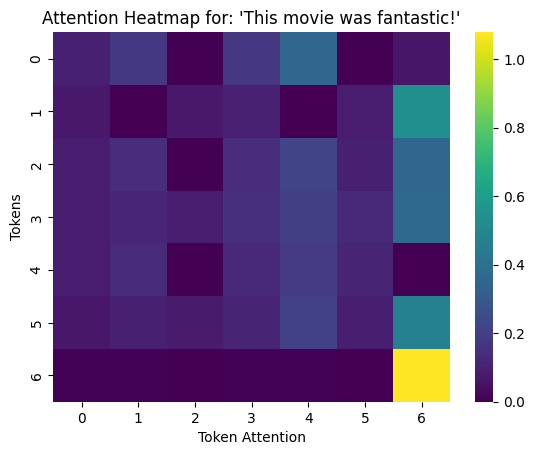

In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load IMDB data
def load_imdb_data(data_file):
    df = pd.read_csv(data_file)
    texts = df['review'].tolist()
    labels = [1 if sentiment == "positive" else 0 for sentiment in df['sentiment'].tolist()]
    return texts, labels

# Dataset class for sentiment analysis
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Function to train the model
def train_model(model, dataloader, optimizer, criterion, device, epochs=1):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}")
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        print(f"Epoch {epoch + 1}, Avg Loss: {epoch_loss / len(dataloader)}")

# Function to visualize the attention heatmap
def visualize_attention(model, tokenizer, text, device):
    # Forward pass to get attention weights
    inputs = tokenizer(text, return_tensors='pt', add_special_tokens=True).to(device)
    outputs = model(**inputs, output_attentions=True)

    # Access attention weights
    attention_weights = outputs.attentions  # List of attention matrices from each layer
    last_layer_attention = attention_weights[-1]  # Get attention from the last layer
    attention_matrix = last_layer_attention[0].detach().cpu().numpy()  # Shape: (batch_size, num_heads, seq_len, seq_len)

    # Plotting the heatmap for the first attention head and first token
    sns.heatmap(attention_matrix[0], cmap="viridis")
    plt.title(f"Attention Heatmap for: '{text}'")
    plt.xlabel("Token Attention")
    plt.ylabel("Tokens")
    plt.show()

# Main function to execute the process
if __name__ == "__main__":
    # Load the IMDB data
    data_file = "IMDB Dataset.csv"  # Path to your IMDB dataset
    texts, labels = load_imdb_data(data_file)

    # Load tokenizer and model
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

    # Check if GPU is available and set the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Prepare dataset and dataloader
    dataset = SentimentDataset(texts, labels, tokenizer, max_len=64)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

    # Optimizer and loss function
    optimizer = AdamW(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()

    # Train the model
    train_model(model, dataloader, optimizer, criterion, device, epochs=1)

    # Visualize attention heatmap for a sample sentence from the dataset
    visualize_attention(model, tokenizer, "This movie was fantastic!", device)


In [3]:
def visualize_attention(model, tokenizer, text, device):
    model.eval()  # Set model to evaluation mode

    # Tokenize the input text and get tokens
    inputs = tokenizer(text, return_tensors='pt', add_special_tokens=True, truncation=True, max_length=64).to(device)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())  # Get token list
    
    # Forward pass to get attention weights
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # Access attention weights
    attention_weights = outputs.attentions  # List of attention matrices from each layer
    print(f"Number of layers: {len(attention_weights)}")
    last_layer_attention = attention_weights[-1]  # Get attention from the last layer
    attention_matrix = last_layer_attention[0].detach().cpu().numpy()  # Shape: (batch_size, num_heads, seq_len, seq_len)

    # Plotting the heatmap for the first attention head (attention_matrix[0])
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(attention_matrix[0], cmap="viridis", xticklabels=tokens, yticklabels=tokens, ax=ax, vmin=0, vmax=1)
    
    # Title and labels
    ax.set_title(f"Attention Heatmap for: '{text}'", fontsize=16)
    ax.set_xlabel("Token Attention", fontsize=12)
    ax.set_ylabel("Tokens", fontsize=12)
    
    plt.xticks(rotation=90)  # Rotate x-axis token labels for readability
    plt.show()
def predict_sentiment(model, tokenizer, sentence, device):
    model.eval()  # Set the model to evaluation mode
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=64, padding='max_length').to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    sentiment = "Positive" if predicted_class == 1 else "Negative"
    
    print(f"Predicted sentiment for \"{sentence}\": {sentiment}")
    return sentiment

Predicted sentiment for "I enjoyed his movie and like it": Positive


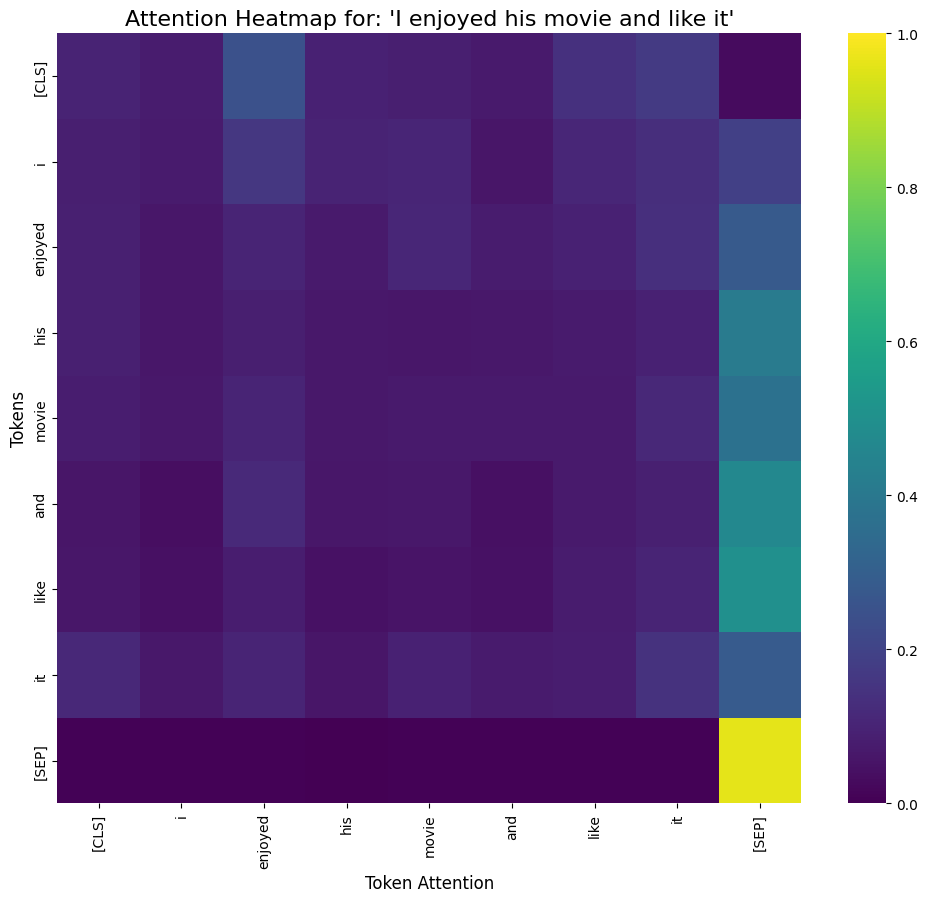

In [10]:
test_sentence = "I enjoyed his movie and like it"
predict_sentiment(model, tokenizer, test_sentence, device)

# Visualize attention heatmap for the same sentence
visualize_attention(model, tokenizer, test_sentence, device)